In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [31]:
# Constants
DATASET_DIR = R"C:\Users\admin\Desktop\BEA-Capstone\data\behavior"
MAX_FRAMES = 10
POSE_FEATURES = 33 * 2
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 0.0001
CLIP_NORM = 1.0 

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Action Labels
action_map = {
    "Sit down": 0,
    "Standing up": 1
}

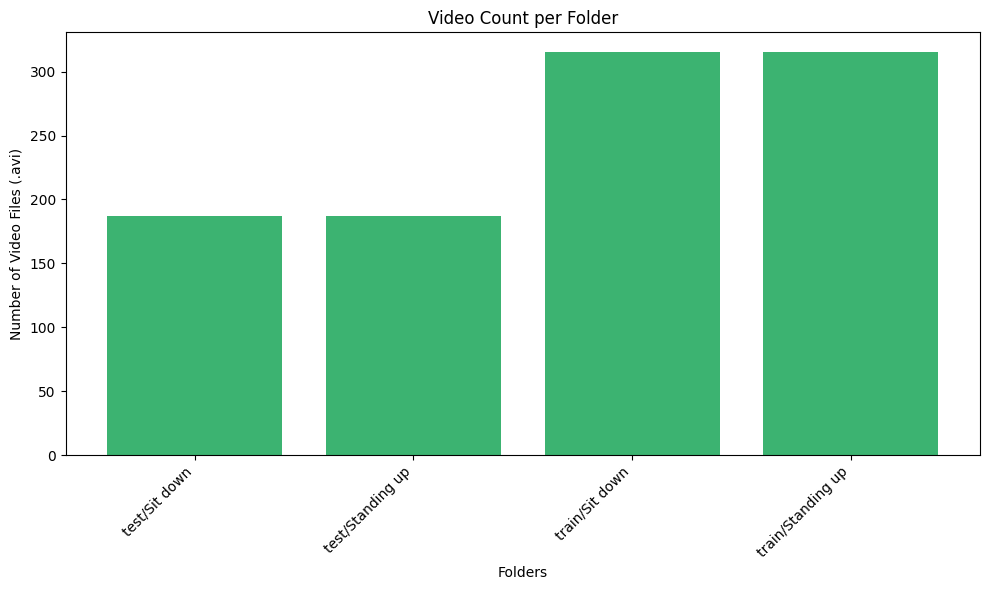

In [3]:
import os
import matplotlib.pyplot as plt

base_path = r'C:\Users\admin\Desktop\BEA-Capstone\data\behavior'

# Supported video extensions
video_exts = ('.avi',)

# Dictionary to hold counts
video_counts = {}

# Loop through categories and folders
for action in os.listdir(base_path):
    action_path = os.path.join(base_path, action)
    if os.path.isdir(action_path):
        for subfolder in os.listdir(action_path):
            folder_path = os.path.join(action_path, subfolder)
            if os.path.isdir(folder_path):
                video_files = [f for f in os.listdir(folder_path) if f.lower().endswith(video_exts)]
                label = f"{action}/{subfolder}"
                video_counts[label] = len(video_files)

plt.figure(figsize=(10, 6))
plt.bar(video_counts.keys(), video_counts.values(), color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Folders")
plt.ylabel("Number of Video Files (.avi)")
plt.title("Video Count per Folder")
plt.tight_layout()
plt.show()

In [4]:
# Define LTSM Model

class ActionLSTM(nn.Module):
    def __init__(self, input_size=POSE_FEATURES, hidden_size=128, num_classes=2, num_layers=2, bidirectional=True, dropout=0.4):
        super(ActionLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [5]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
from torch.utils.data import Dataset

DATASET_DIR = r'C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train'

# Action mapping
action_map = {
    "Sit down": 0,
    "Standing up": 1
}

class PoseDataset(Dataset):
    def __init__(self, data_dir, action_map, max_frames=MAX_FRAMES):
        self.data = []
        self.labels = []
        self.max_frames = max_frames
        self.action_map = action_map
        self._load_data(data_dir)

    def _load_data(self, data_dir):
        mp_pose = mp.solutions.pose
        pose = mp_pose.Pose(static_image_mode=False)
        total_videos = 0
        processed_videos = 0

        for action in os.listdir(data_dir):
            action_path = os.path.join(data_dir, action)
            if not os.path.isdir(action_path):
                continue

            for video_file in os.listdir(action_path):
                if not video_file.lower().endswith('.avi'):
                    continue

                total_videos += 1
                video_path = os.path.join(action_path, video_file)
                cap = cv2.VideoCapture(video_path)

                if not cap.isOpened():
                    print(f"[Warning] Cannot open video file: {video_path}")
                    continue

                keypoints = []
                frame_count = 0

                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = pose.process(frame_rgb)

                    if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        frame_keypoints = []
                        for lm in landmarks:
                            frame_keypoints.extend([lm.x, lm.y])
                        keypoints.append(frame_keypoints)
                        frame_count += 1

                    if frame_count >= self.max_frames:
                        break

                cap.release()

                if len(keypoints) == 0:
                     print(f"[Info] Skipping video (no pose detected): {video_path}")
                     continue

                # Pad with zeros if too short
                if len(keypoints) < self.max_frames:
                     print(f"[Info] Padding video: {video_path} (only {len(keypoints)} frames)")
                while len(keypoints) < self.max_frames:
                       keypoints.append([0.0] * len(keypoints[0]))


                label = self.action_map.get(action, -1)
                if label == -1:
                    print(f"[Warning] Unknown label for action: {action}")
                    continue

                self.data.append(keypoints)
                self.labels.append(label)
                processed_videos += 1

        pose.close()
        print(f"[Summary] Total videos found: {total_videos}")
        print(f"[Summary] Videos processed successfully: {processed_videos}")
        print(f"[Summary] Total samples loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = np.array(self.data[idx], dtype=np.float32)
        label = self.labels[idx]
        return torch.tensor(sequence), torch.tensor(label)

# Load dataset from the corrected path
dataset = PoseDataset(data_dir=DATASET_DIR, action_map=action_map)
print(f"Dataset size: {len(dataset)}")


[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_100.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_100_flip.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_101_flip.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_103.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_103_flip.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_104.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_104_flip.avi
[Info] Padding video: C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_105_flip.avi (only 4 frames)
[Info] Padd

import os

DATASET_DIR = R"C:\Users\admin\Desktop\BEA-Capstone\data\behavior"
print("Dataset directory exists:", os.path.exists(DATASET_DIR))
print("Contents:", os.listdir(DATASET_DIR))

In [6]:
# Load the dataset

from torch.utils.data import DataLoader, random_split

dataset = PoseDataset(DATASET_DIR, action_map)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_100.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_100_flip.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_101_flip.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_103.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_103_flip.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_104.avi
[Info] Skipping video (no pose detected): C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_104_flip.avi
[Info] Padding video: C:\Users\admin\Desktop\BEA-Capstone\data\behavior\train\Sit down\video_105_flip.avi (only 4 frames)
[Info] Padd

In [41]:
# Initialize model

model = ActionLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [42]:
# Training

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total_predictions += val_labels.size(0)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.4f}')

Epoch 1/30, Train Loss: 0.6905, Train Acc: 0.5023, Val Loss: 0.6856, Val Acc: 0.5625
Epoch 2/30, Train Loss: 0.6749, Train Acc: 0.6802, Val Loss: 0.6656, Val Acc: 0.5982
Epoch 3/30, Train Loss: 0.6175, Train Acc: 0.6892, Val Loss: 0.5840, Val Acc: 0.7143
Epoch 4/30, Train Loss: 0.5532, Train Acc: 0.7297, Val Loss: 0.5033, Val Acc: 0.7857
Epoch 5/30, Train Loss: 0.5054, Train Acc: 0.7477, Val Loss: 0.4530, Val Acc: 0.7946
Epoch 6/30, Train Loss: 0.4879, Train Acc: 0.7590, Val Loss: 0.4495, Val Acc: 0.8125
Epoch 7/30, Train Loss: 0.4731, Train Acc: 0.7590, Val Loss: 0.4148, Val Acc: 0.7679
Epoch 8/30, Train Loss: 0.4858, Train Acc: 0.7680, Val Loss: 0.4074, Val Acc: 0.8036
Epoch 9/30, Train Loss: 0.4598, Train Acc: 0.7770, Val Loss: 0.5625, Val Acc: 0.6875
Epoch 10/30, Train Loss: 0.4542, Train Acc: 0.7770, Val Loss: 0.3904, Val Acc: 0.8304
Epoch 11/30, Train Loss: 0.4395, Train Acc: 0.7928, Val Loss: 0.4047, Val Acc: 0.8125
Epoch 12/30, Train Loss: 0.4262, Train Acc: 0.7973, Val Loss: 0

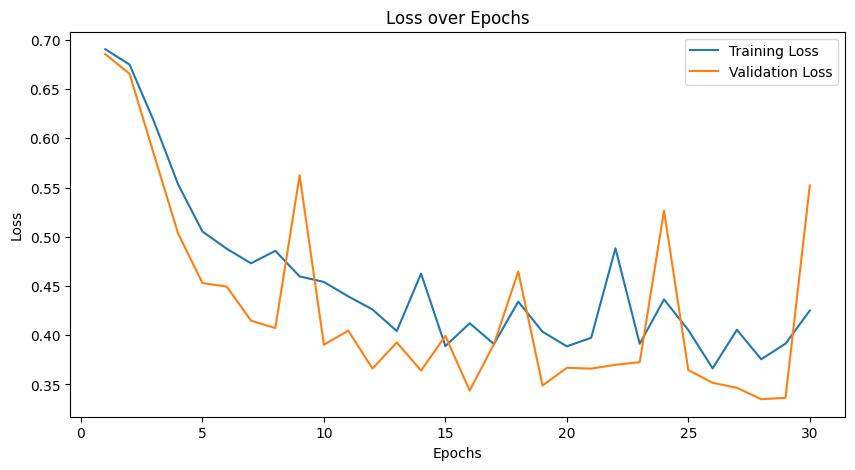

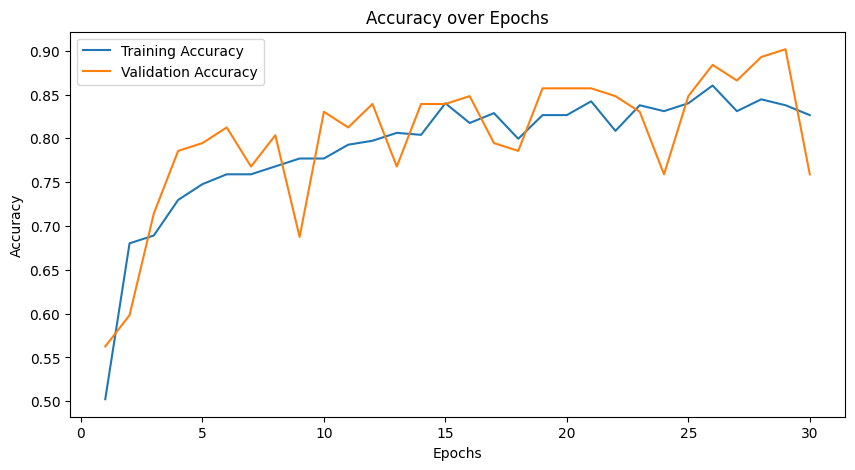

In [43]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Sit down       0.86      0.85      0.85        52
 Standing up       0.87      0.88      0.88        60

    accuracy                           0.87       112
   macro avg       0.87      0.86      0.87       112
weighted avg       0.87      0.87      0.87       112



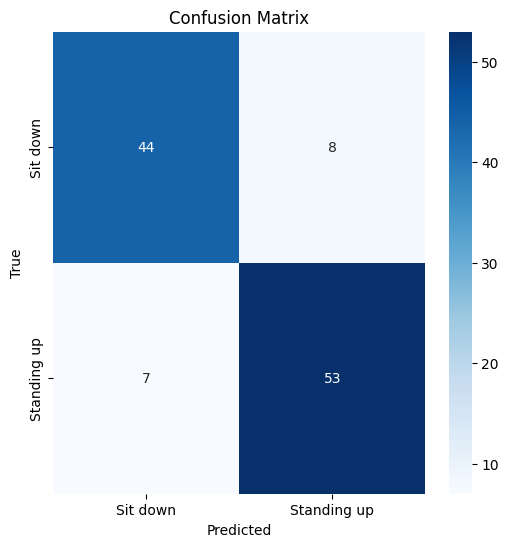

In [37]:
# Evaluation

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model(val_inputs)
        _, val_predicted = torch.max(val_outputs.data, 1)

        all_preds.extend(val_predicted.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=action_map.keys()))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=action_map.keys(), yticklabels=action_map.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Save model

torch.save(model.state_dict(), 'sit-stand_lstm_model.pth')

In [46]:
# Load best model from previous training if you saved it
model.load_state_dict(torch.load("sit-stand_lstm_model.pth"))

# 2. Fine-tuning settings
FINE_TUNE_EPOCHS = 10
FINE_TUNE_LR = 1e-5  # Lower learning rate for fine-tuning
fine_tune_optimizer = optim.Adam(model.parameters(), lr=FINE_TUNE_LR)

print("\n🔧 Starting fine-tuning...")

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    fine_tune_loss = 0.0
    correct_ft = 0
    total_ft = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        fine_tune_optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        fine_tune_optimizer.step()

        fine_tune_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        total_ft += labels.size(0)
        correct_ft += (preds == labels).sum().item()

    train_acc_ft = correct_ft / total_ft
    train_loss_ft = fine_tune_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss_ft = 0.0
    val_correct_ft = 0
    val_total_ft = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_loss_ft += val_loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs.data, 1)
            val_total_ft += val_labels.size(0)
            val_correct_ft += (val_preds == val_labels).sum().item()

    val_acc_ft = val_correct_ft / val_total_ft
    val_loss_ft = val_loss_ft / len(val_loader.dataset)

    # Track metrics
    train_losses.append(train_loss_ft)
    train_accuracies.append(train_acc_ft)
    val_losses.append(val_loss_ft)
    val_accuracies.append(val_acc_ft)

    print(f'[Finetune Epoch {epoch+1}/{FINE_TUNE_EPOCHS}] '
          f'Train Loss: {train_loss_ft:.4f}, Train Acc: {train_acc_ft:.4f}, '
          f'Val Loss: {val_loss_ft:.4f}, Val Acc: {val_acc_ft:.4f}')



🔧 Starting fine-tuning...
[Finetune Epoch 1/10] Train Loss: 0.3565, Train Acc: 0.8491, Val Loss: 0.3250, Val Acc: 0.8929
[Finetune Epoch 2/10] Train Loss: 0.3450, Train Acc: 0.8671, Val Loss: 0.3550, Val Acc: 0.8750
[Finetune Epoch 3/10] Train Loss: 0.3416, Train Acc: 0.8581, Val Loss: 0.3470, Val Acc: 0.8750
[Finetune Epoch 4/10] Train Loss: 0.3434, Train Acc: 0.8761, Val Loss: 0.3341, Val Acc: 0.8839
[Finetune Epoch 5/10] Train Loss: 0.3143, Train Acc: 0.8896, Val Loss: 0.3464, Val Acc: 0.8839
[Finetune Epoch 6/10] Train Loss: 0.3202, Train Acc: 0.8784, Val Loss: 0.3359, Val Acc: 0.8929
[Finetune Epoch 7/10] Train Loss: 0.3258, Train Acc: 0.8739, Val Loss: 0.3454, Val Acc: 0.8839
[Finetune Epoch 8/10] Train Loss: 0.3359, Train Acc: 0.8694, Val Loss: 0.3508, Val Acc: 0.8839
[Finetune Epoch 9/10] Train Loss: 0.3108, Train Acc: 0.8851, Val Loss: 0.3454, Val Acc: 0.8839
[Finetune Epoch 10/10] Train Loss: 0.3275, Train Acc: 0.8784, Val Loss: 0.3514, Val Acc: 0.8839


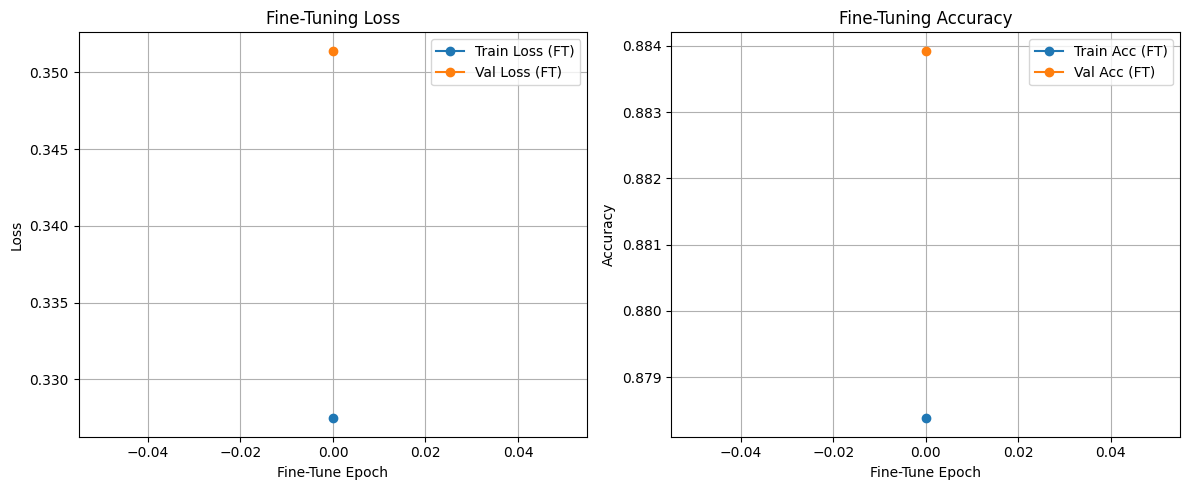

In [49]:
# Separate lists for fine-tuning only
ft_train_losses = []
ft_val_losses = []
ft_train_accuracies = []
ft_val_accuracies = []

ft_train_losses.append(train_loss_ft)
ft_train_accuracies.append(train_acc_ft)
ft_val_losses.append(val_loss_ft)
ft_val_accuracies.append(val_acc_ft)

import matplotlib.pyplot as plt

# Plot ONLY fine-tuning loss and accuracy
plt.figure(figsize=(12, 5))

# Fine-tuning Loss
plt.subplot(1, 2, 1)
plt.plot(ft_train_losses, label='Train Loss (FT)', marker='o')
plt.plot(ft_val_losses, label='Val Loss (FT)', marker='o')
plt.title("Fine-Tuning Loss")
plt.xlabel("Fine-Tune Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Fine-tuning Accuracy
plt.subplot(1, 2, 2)
plt.plot(ft_train_accuracies, label='Train Acc (FT)', marker='o')
plt.plot(ft_val_accuracies, label='Val Acc (FT)', marker='o')
plt.title("Fine-Tuning Accuracy")
plt.xlabel("Fine-Tune Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
import cv2
import mediapipe as mp
import time
import numpy as np

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Webcam setup
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open webcam")
    exit()

# Tracking variables
prev_state = "Unknown"
current_state = "Unknown"
standing_now = False
stand_count = 0
cooldown = 0  # To avoid multiple detections in a short period

# Helper function to classify posture
def classify_posture(landmarks):
    left_hip = landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y
    right_hip = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y
    left_knee = landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE].y
    right_knee = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y

    hip_avg = (left_hip + right_hip) / 2
    knee_avg = (left_knee + right_knee) / 2

    return "Sitting" if abs(hip_avg - knee_avg) < 0.1 else "Standing"

print("Starting posture classification... Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        current_state = classify_posture(results.pose_landmarks)
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Count standing ups
        if current_state == "Standing" and prev_state == "Sitting" and not standing_now:
            stand_count += 1
            standing_now = True
            cooldown = 10  # frames before allowing next stand detection
            print(f"STAND DETECTED! Total: {stand_count}")

        # Reset standing state after cooldown or if sitting again
        if standing_now:
            cooldown -= 1
            if cooldown <= 0 or current_state == "Sitting":
                standing_now = False

        prev_state = current_state
    else:
        current_state = "No person detected"

    # Display info
    color = (0, 255, 0) if current_state == "Standing" else (0, 0, 255)
    cv2.putText(frame, f"Posture: {current_state}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.putText(frame, f"Stand Count: {stand_count}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv2.imshow("Sit-to-Stand Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print(f"Final Stand Count: {stand_count}")

Starting posture classification... Press 'q' to quit.
Final Stand Count: 0
